<a href="https://colab.research.google.com/github/yazeedMohi/Handwritten-Text-Recognition-Arabic-and-English-/blob/master/Handwritten_Text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Handwritten Arabic text recognition**


## Configuring Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 2.1

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Tensorboard

In [0]:
#output_path = os.path.join("/content/drive/My Drive/", "output", "khattx", "yazeed")
%load_ext tensorboard
%tensorboard --reload_interval=300 --logdir={output}

## Run Here


####################################

Prob.  - Predict
0.0010501214 - الشاني ربها جعلت هذا البلد في وضع
0.000777716 - الشاني ربها جعلت هذا البلد في وضيع
0.0005211217 - الشاني ربها جعلت هذا البل في وضع
0.00037871144 - الثاني ربها جعلت هذا البلد في وضع
0.0002918352 - الشاني ربها جهلت هذا البلد في وضع
0.00026788222 - الشاني ربها جعلت هذا البلة في وضع
0.00020035134 - الشاني ربها جعلت هذا البلد في وضبع
6.604857e-05 - الشاني ربها جعلت هذا البلد في وضح
4.8915324e-05 - الشاني ربها جعلت هذا البلد في وضيح
3.2776523e-05 - الشاني ربها جعلت هذا البل في وضح


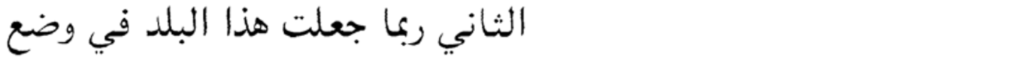


####################################


In [0]:

"""
* source: dataset/model name (iam, rimes, khatt, khattx)
* arch: network to be used (puigcerver, bluche, yazeed)
* transform: transform dataset to the HDF5 file (hdf5 files are better for processing and training)
* cv2: visualize sample from transformed dataset
* image: predict a single image with the source parameter
* train: train model with the source argument
* test: evaluate and predict model with the source argument
* epochs: number of epochs
* batch_size: number of batches
"""
# NOTE: KHATTX is the cleaned version of KHATT that I created, use KHATT without an "X" for the vanilla KHATT.
Main(source="khattx",image="/content/drive/My Drive/data/demo/sec.PNG")

## Main

In [0]:
"""
Provides general interface to the project.
"""

import argparse
import cv2
import h5py
import os
import string
import datetime

from google.colab.patches import cv2_imshow

arabic = True

def Main(source,arch="yazeed",transform=False,ocv2=False,image="",train=False,test=False,epochs=1000,batch_size=16):

    # Change those as needed
    raw_path = "/content"
    source_path = os.path.join("/content/drive/My Drive/", "data", str(source)+".hdf5")
    output_path = os.path.join("/content/drive/My Drive/", "output", source, arch)
    target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
    
    
    if(source.find("khatt") != -1):
        arabic = True
        # Best size for KHATT & KHATTX
        input_size = (1024, 64, 1)
        charset_base = 'ءآأإابتةثجحخدذرزسشصضطظعغفقكلمنؤهويىئ0123456789@:,.?!"()//\=-_#%$^&*+ '
    else:
        arabic = False
        input_size = (1024, 128, 1)
        charset_base = string.printable[:95]
    max_text_length = 128
    if transform:
        # Transforming dataset to HDF5 format
        
        assert os.path.exists(raw_path) # Otherwise raise exception
        
        print("The "+str(source)+" dataset will be transformed...")

        ds = Dataset(source=raw_path, name=source)
        ds.read_partitions()
        
        print("Partitions will be preprocessed...")
        ds.preprocess_partitions(input_size=input_size)

        print("Partitions will be saved...")
        os.makedirs(os.path.dirname(source_path), exist_ok=True)
        for i in ds.partitions:
            with h5py.File(source_path, "a") as hf:
                cv2_imshow(ds.dataset[i]['dt'][0])
                hf.create_dataset(str(i)+"/dt", data=ds.dataset[i]['dt'], compression="gzip", compression_opts=9)
                hf.create_dataset(str(i)+"/gt", data=ds.dataset[i]['gt'], compression="gzip", compression_opts=9)
                print("[OK] "+str(i)+" partition.")
        print("Transformation finished.")

    elif ocv2:
        # Visualising the prediction vs original label for a subset of the testing set
        with h5py.File(source_path, "r") as hf:
            dt = hf['test']['dt'][:256]
            gt = hf['test']['gt'][:256]

        predict_file = os.path.join(output_path, "predict.txt")
        predicts = [''] * len(dt)

        if os.path.isfile(predict_file):
            with open(predict_file, "r") as lg:
                predicts = [line[4:] for line in lg if line.startswith("TE_P")]

        for x in range(len(dt)):
            cv2_imshow( adjust_to_see(dt[x]))
            print("Image shape:\t"+str(dt[x].shape))
            print("Ground truth:\t"+str(gt[x].decode()))
            print("Predict:\t"+str(predicts[x])+"\n")


    elif image:
        # Testing for a single image
        tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)

        img = preprocess(image, input_size=input_size)
        x_test = normalization([img])

        model = NNModel(architecture=arch,
                         input_size=input_size,
                         vocab_size=tokenizer.vocab_size,
                         top_paths=10)

        model.compile()
        model.load_checkpoint(target=target_path)

        predicts, probabilities = model.predict(x_test, ctc_decode=True)
        predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

        print("\n####################################")
        for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
            print("\nProb.  - Predict")

            for (pd, pb) in zip(pred, prob):
                print(str(pb)+" - "+str(pd))

            cv2_imshow(adjust_to_see(img))
        print("\n####################################")

    else:
        # Either training or testing
        assert os.path.isfile(source_path) or os.path.isfile(target_path)
        os.makedirs(output_path, exist_ok=True)

        dtgen = DataGenerator(source=source_path,
                              batch_size=batch_size,
                              charset=charset_base,
                              max_text_length=max_text_length,
                              predict=test)
        # Creating a model
        model = NNModel(architecture=arch,
                         input_size=input_size,
                         vocab_size=dtgen.tokenizer.vocab_size)

        # set `learning_rate` parameter or get architecture default value
        model.compile(learning_rate=0.001)
        model.load_checkpoint(target=target_path) # Very useful with the colab issue we talked about yesterday
        
        if train:
            print(f"Train images: {dtgen.size['train']}")
            print(f"Validation images: {dtgen.size['valid']}")
            print(f"Test images: {dtgen.size['test']}")
            model.summary(output_path, "summary.txt")
            callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)
            start_time = datetime.datetime.now()
            h = model.fit(x=dtgen.next_train_batch(),
                          epochs=epochs,
                          steps_per_epoch=dtgen.steps['train'],
                          validation_data=dtgen.next_valid_batch(),
                          validation_steps=dtgen.steps['valid'],
                          callbacks=callbacks,
                          shuffle=True,
                          verbose=1)

            total_time = datetime.datetime.now() - start_time

            loss = h.history['loss']
            val_loss = h.history['val_loss']

            min_val_loss = min(val_loss)
            min_val_loss_i = val_loss.index(min_val_loss)

            time_epoch = (total_time / len(loss))
            total_item = (dtgen.size['train'] + dtgen.size['valid'])
            t_corpus = ""
            t_corpus = "\n".join([
                f"Total train images:      {dtgen.size['train']}",
                f"Total validation images: {dtgen.size['valid']}",
                f"Batch:                   {dtgen.batch_size}\n",
                f"Total time:              {total_time}",
                f"Time per epoch:          {time_epoch}",
                f"Time per item:           {time_epoch / total_item}\n",
                f"Total epochs:            {len(loss)}",
                f"Best epoch               {min_val_loss_i + 1}\n",
                f"Training loss:           {loss[min_val_loss_i]:.8f}",
                f"Validation loss:         {min_val_loss:.8f}"
            ])

            with open(os.path.join(output_path, "train.txt"), "w") as lg:
                lg.write(t_corpus)
                print(t_corpus)

        elif test:
            print(f"Test images: {dtgen.size['test']}")
            start_time = datetime.datetime.now()

            predicts, _ = model.predict(x=dtgen.next_test_batch(),
                                        steps=dtgen.steps['test'],
                                        ctc_decode=True,
                                        verbose=1)

            predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

            total_time = datetime.datetime.now() - start_time

            with open(os.path.join(output_path, "predict.txt"), "w") as lg:
                for pd, gt in zip(predicts, dtgen.dataset['test']['gt']):
                    lg.write("TE_L "+str(gt)+"\nTE_P" +str(pd)+"\n")

            evaluate = ocr_metrics(predicts=predicts,
                                              ground_truth=dtgen.dataset['test']['gt'],
                                              norm_accentuation=False,
                                              norm_punctuation=False)

            e_corpus = ""
            e_corpus = "\n".join([
                f"Total test images:    {dtgen.size['test']}",
                f"Total time:           {total_time}",
                f"Time per item:        {total_time / dtgen.size['test']}\n",
                f"Metrics:",
                f"Character Error Rate: {evaluate[0]:.8f}",
                f"Word Error Rate:      {evaluate[1]:.8f}",
                f"Sequence Error Rate:  {evaluate[2]:.8f}"
            ])

            with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
                lg.write(e_corpus)
                print(e_corpus)

## Layers

In [0]:
"""
Gated implementations
    GatedConv2D: Introduce a Conv2D layer (same number of filters) to multiply with its sigmoid activation.
    FullGatedConv2D: Introduce a Conv2D to extract features (linear and sigmoid), making a full gated process.
                     This process will double number of filters to make one convolutional process.
"""

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation


class GatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, **kwargs):
        super(GatedConv2D, self).__init__(**kwargs)

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(GatedConv2D, self).call(inputs)
        linear = Activation("linear")(inputs)
        sigmoid = Activation("sigmoid")(output)

        return Multiply()([linear, sigmoid])

    def get_config(self):
        """Return the config of the layer"""

        config = super(GatedConv2D, self).get_config()
        return config


"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        filters (int): Number of output filters.
        kwargs: Other Conv2D keyword arguments.
"""


class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

## Models

In [0]:
"""Handwritten Text Recognition Neural Network"""

import os
import numpy as np
import tensorflow as tf

from contextlib import redirect_stdout
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm

from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape


"""
NNModel Class
The NNModel class use Tensorflow 2 Keras module for the use of the
Connectionist Temporal Classification (CTC) with the Hadwritten Text Recognition.

x is the input features and y the labels.
"""


class NNModel:

    def __init__(self,
                 architecture,
                 input_size,
                 vocab_size,
                 greedy=False,
                 beam_width=10,
                 top_paths=1):
        """
        Initialization of a NN Model.

        parameters:
            architecture: option of the architecture model to build and compile
            greedy, beam_width, top_paths: Parameters of the CTC decoding
        """

        self.architecture = globals()[architecture]
        self.input_size = input_size
        self.vocab_size = vocab_size

        self.model = None
        self.greedy = greedy
        self.beam_width = beam_width
        self.top_paths = max(1, top_paths)
    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            with open(os.path.join(output, target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                histogram_freq=10,
                profile_batch=0,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=20, # Change this if the training keeps stopping, happened to me earlier.
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=0.2,
                patience=15,
                verbose=verbose)
        ]

        return callbacks

    def compile(self, learning_rate=None):
        """
        Configures the NN Model for training/predict.

        optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        outs = self.architecture(self.input_size, self.vocab_size + 1, learning_rate)
        inputs, outputs, optimizer = outs

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.ctc_loss_lambda_func)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            **kwargs):
        """
        Model training on data yielded (fit function has support to generator).
        A fit() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding (x, y, sample_weight).

        return: A history object
        """

        out = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                             callbacks=callbacks, validation_split=validation_split,
                             validation_data=validation_data, shuffle=shuffle,
                             class_weight=class_weight, sample_weight=sample_weight,
                             initial_epoch=initial_epoch, steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps, validation_freq=validation_freq,
                             max_queue_size=max_queue_size, workers=workers,
                             use_multiprocessing=use_multiprocessing, **kwargs)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                ctc_decode=True):
        """
        Model predicting on data yielded (predict function has support to generator).
        A predict() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding [x].

        returns: raw data on `ctc_decode=False` or CTC decode on `ctc_decode=True` (both with probabilities)
        """

        self.model._make_predict_function()

        if verbose == 1:
            print("Model Predict")

        out = self.model.predict(x=x, batch_size=batch_size, verbose=verbose, steps=steps,
                                 callbacks=callbacks, max_queue_size=max_queue_size,
                                 workers=workers, use_multiprocessing=use_multiprocessing)

        if not ctc_decode:
            return np.log(out.clip(min=1e-8))

        steps_done = 0
        if verbose == 1:
            print("CTC Decode")
            progbar = tf.keras.utils.Progbar(target=steps)

        batch_size = int(np.ceil(len(out) / steps))
        input_length = len(max(out, key=len))

        predicts, probabilities = [], []

        while steps_done < steps:
            index = steps_done * batch_size
            until = index + batch_size

            x_test = np.asarray(out[index:until])
            x_test_len = np.asarray([input_length for _ in range(len(x_test))])

            decode, log = K.ctc_decode(x_test,
                                       x_test_len,
                                       greedy=self.greedy,
                                       beam_width=self.beam_width,
                                       top_paths=self.top_paths)

            probabilities.extend([np.exp(x) for x in log])
            decode = [[[int(p) for p in x if p != -1] for x in y] for y in decode]
            predicts.extend(np.swapaxes(decode, 0, 1))

            steps_done += 1
            if verbose == 1:
                progbar.update(steps_done)

        return (predicts, probabilities)

    @staticmethod
    def ctc_loss_lambda_func(y_true, y_pred):
        """Function for computing the CTC loss"""

        if len(y_true.shape) > 2:
            y_true = tf.squeeze(y_true)

        # y_pred.shape = (batch_size, string_length, alphabet_size_1_hot_encoded)
        # output of every model is softmax
        # so sum across alphabet_size_1_hot_encoded give 1
        #               string_length give string length
        input_length = tf.math.reduce_sum(y_pred, axis=-1, keepdims=False)
        input_length = tf.math.reduce_sum(input_length, axis=-1, keepdims=True)

        # y_true strings are padded with 0
        # so sum of non-zero gives number of characters in this string
        label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True, dtype="int64")

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

        # average loss across all entries in the batch
        loss = tf.reduce_mean(loss)

        return loss


"""
Networks to the Handwritten Text Recognition Model
"""


def bluche(input_size, d_model, learning_rate):
    """
    Gated Convolucional Recurrent Neural Network by Bluche et al.

    Reference:
        Bluche, T., Messina, R.:
        Gated convolutional recurrent neural networks for multilingual handwriting recognition.
    """

    input_data = Input(name="input", shape=input_size)
    cnn = Reshape((input_size[0] // 2, input_size[1] // 2, input_size[2] * 4))(input_data)

    cnn = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding="same", activation="tanh")(cnn)

    cnn = Conv2D(filters=16, kernel_size=(2,4), strides=(2,4), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)

    cnn = Conv2D(filters=64, kernel_size=(2,4), strides=(2,4), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)

    cnn = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation="tanh")(cnn)
    cnn = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding="valid")(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True))(blstm)
    blstm = Dense(units=128, activation="tanh")(blstm)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True))(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    if learning_rate is None:
        learning_rate = 4e-4

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    return (input_data, output_data, optimizer)


def puigcerver(input_size, d_model, learning_rate):
    """
    Convolutional Recurrent Neural Network by Puigcerver et al.

    Reference:
        Joan Puigcerver.
        Are multidimensional recurrent layers really necessary for handwritten text recognition?
    """

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding="same")(input_data)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=80, kernel_size=(3,3), strides=(1,1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)

    blstm = Dropout(rate=0.5)(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    if learning_rate is None:
        learning_rate = 3e-4

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    return (input_data, output_data, optimizer)

def yazeed(input_size, d_model, learning_rate):
    """
    Gated Convolutional Recurrent Neural Network by Yazeed Mohi-Eldeen Sabil.
    Based on the Flor et al architecture, modified some portions to fit the KHATT dataset. 
    """

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding="same", kernel_initializer="he_uniform")(input_data)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=16, kernel_size=(3,3), padding="same")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=32, kernel_size=(3,3), padding="same")(cnn)

    cnn = Conv2D(filters=40, kernel_size=(2,4), strides=(2,4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=40, kernel_size=(3,3), padding="same", kernel_constraint=MaxNorm(4, [0,1,2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=48, kernel_size=(3,3), padding="same", kernel_constraint=MaxNorm(4, [0,1,2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=56, kernel_size=(2,4), strides=(2,4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=56, kernel_size=(3,3), padding="same", kernel_constraint=MaxNorm(4, [0,1,2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1,2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)

    cnn = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding="valid")(cnn)

    shape = cnn.get_shape()
    nb_units = shape[2] * shape[3]

    bgru = Reshape((shape[1], nb_units))(cnn)

    bgru = Bidirectional(GRU(units=nb_units, return_sequences=True, dropout=0.5))(bgru)
    bgru = Dense(units=nb_units * 2)(bgru)

    bgru = Bidirectional(GRU(units=nb_units, return_sequences=True, dropout=0.5))(bgru)
    output_data = Dense(units=d_model, activation="softmax")(bgru)

    if learning_rate is None:
        learning_rate = 5e-4

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    return (input_data, output_data, optimizer)

## Evaluation

In [0]:
"""
Tool to metrics calculation through data and label (string and string).
Calculation from Optical Character Recognition (OCR) metrics with editdistance.
"""

import string
import unicodedata
import editdistance
import numpy as np


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics

## Generator

In [0]:
"""
Uses generator functions to supply train/test with data.
Creates and supplies data as needed.
"""

from tensorflow.keras.preprocessing.sequence import pad_sequences

import h5py
import numpy as np
import unicodedata


class DataGenerator():
    """Generator class"""

    def __init__(self, source, batch_size, charset, max_text_length, predict=False):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.batch_size = batch_size
        self.partitions = ['test'] if predict else ['train', 'valid', 'test']

        self.size = dict()
        self.steps = dict()
        self.index = dict()
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            for pt in self.partitions:
                self.dataset[pt] = dict()
                self.dataset[pt]['dt'] = f[pt]['dt'][:]
                self.dataset[pt]['gt'] = f[pt]['gt'][:]
        for pt in self.partitions:
            # decode sentences from byte
            self.dataset[pt]['gt'] = [x.decode() for x in self.dataset[pt]['gt']]

            # set size and setps
            self.size[pt] = len(self.dataset[pt]['gt'])
            self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))
            self.index[pt] = 0
    def next_train_batch(self):
        """Get the next batch from train partition (yield)"""
        while True:
            if self.index['train'] >= self.size['train']:
                self.index['train'] = 0

            index = self.index['train']
            until = self.index['train'] + self.batch_size
            self.index['train'] = until

            x_train = self.dataset['train']['dt'][index:until]
            y_train = self.dataset['train']['gt'][index:until]

            x_train = augmentation(x_train,
                                      rotation_range=1.5,
                                      scale_range=0.05,
                                      height_shift_range=0.025,
                                      width_shift_range=0.05,
                                      erode_range=5,
                                      dilate_range=3)

            x_train = normalization(x_train)
            y_train = [self.tokenizer.encode(y) for y in y_train]
            y_train = pad_sequences(y_train, maxlen=self.tokenizer.maxlen, padding="post")
            #print(len(y_train[0]))
            yield (x_train, y_train,[])

    def next_valid_batch(self):
        """Get the next batch from validation partition (yield)"""

        while True:
            if self.index['valid'] >= self.size['valid']:
                self.index['valid'] = 0

            index = self.index['valid']
            until = self.index['valid'] + self.batch_size
            self.index['valid'] = until

            x_valid = self.dataset['valid']['dt'][index:until]
            y_valid = self.dataset['valid']['gt'][index:until]

            x_valid = normalization(x_valid)

            y_valid = [self.tokenizer.encode(y) for y in y_valid]
            y_valid = pad_sequences(y_valid, maxlen=self.tokenizer.maxlen, padding="post")

            yield (x_valid, y_valid, [])

    def next_test_batch(self):
        """Return model predict parameters"""

        while True:
            if self.index['test'] >= self.size['test']:
                self.index['test'] = 0
                break

            index = self.index['test']
            until = self.index['test'] + self.batch_size
            self.index['test'] = until

            x_test = self.dataset['test']['dt'][index:until]
            x_test = normalization(x_test)

            yield x_test

# Found this part online, modified the encoding part to fit the Arabic text.
class Tokenizer():
    """Manages tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK = "¶", "¤" # PAD = Blank white space before and after text, UNK = Unknown character
        self.chars = (self.PAD_TK + self.UNK_TK + chars)

        self.PAD = self.chars.find(self.PAD_TK)
        self.UNK = self.chars.find(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length
    def encode(self, text):
        """Encode text to vector"""

        #text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())
        encoded = []
        for item in text:
            index = self.chars.find(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)
        
        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""

        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "")


## Preprocessing

In [0]:
"""
Data preproc functions:
    adjust_to_see: adjust image to better visualize (rotate and transpose)
    augmentation: apply variations to a list of images
    normalization: apply normalization and variations on images (if required)
    preprocess: main function for preprocess.
        Make the image:
            illumination_compensation: apply illumination regularitation
            remove_cursive_style: remove cursive style from image (if necessary)
            sauvola: apply sauvola binarization
    text_standardize: preprocess and standardize sentence
    generate_multigrams: generate n-grams of the sentence
"""

import re
import cv2
import html
import string
import numpy as np
#import numba as nb

arabic = True
def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))
    if arabic:
      img = cv2.flip(img,1)
    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm.
"""


def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""
    
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    if isinstance(img, tuple):
        image, boundbox = img
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)
    
    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    # Not necessary for the KHATTX dataset, uncomment for IAM or RIMES.
    
    #if np.sum(img) * 0.8 > np.sum(binary):
    #    img = illumination_compensation(img)

    #img = remove_cursive_style(img)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)
    img = cv2.flip(img,0)
    return img


"""
Illumination Compensation based in:
    K.-N. Chen, C.-H. Chen, C.-C. Chang,
    Efficient illumination compensation techniques for text images, in
    Digital Signal Processing.
"""


def illumination_compensation(img):
    """Illumination compensation technique for text image"""

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


"""
Deslating image process based in,
    A. Vinciarelli and J. Luettin,
    A New Normalization Technique for Cursive Handwritten Words.
"""


def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    warp = cv2.warpAffine(img, result[2], result[1], borderValue=255)

    return cv2.resize(warp, dsize=(cols, rows))


"""
Sauvola binarization
"""


def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


"""
DeepSpell based text cleaning process.
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: " "+str(c)+" " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


def generate_multigrams(sentence):
    """
    Generate n-grams of the sentence.
    i.e.:
    original sentence: I like code .
        > sentence 1 : I like
        > sentence 2 : I like code .
        > sentence 3 : like
        > sentence 4 : like code .
        > sentence 5 : code .
    """

    tokens = sentence.split()
    tk_length = len(tokens)
    multigrams = []

    for y in range(tk_length):
        new_sentence = True
        support_text = ""

        for x in range(y, tk_length):
            if y == 0 and tk_length > 2 and x == (tk_length - 1):
                continue

            if len(tokens[x]) <= 2 and tokens[x] != tokens[-1]:
                support_text += " "+str(tokens[x])
                continue

            last = ""
            if x > y and len(multigrams) > 0 and not new_sentence:
                last = multigrams[-1]

            multigrams.append((str(last)+str(support_text)+" "+str(tokens[x])).strip())
            new_sentence = False
            support_text = ""

    return multigrams

## Reader

In [0]:
"""Dataset reader and process"""

import os
import html
import string
import xml.etree.ElementTree as ET

from functools import partial
from glob import glob
from multiprocessing import Pool


class Dataset():
    """Dataset class to read images and sentences from base (raw files)"""

    def __init__(self, source, name):
        self.source = source
        self.name = name
        self.dataset = None
        self.partitions = ['train', 'valid', 'test']

    def read_partitions(self):
        """Read images and sentences from dataset"""

        self.dataset = getattr(self, "_"+str(self.name))()

    def preprocess_partitions(self, input_size):
        """Preprocess images and sentences from partitions"""

        for y in self.partitions:
            arange = range(len(self.dataset[y]['gt']))
            for i in reversed(arange):
                text = text_standardize(self.dataset[y]['gt'][i])
                if not self.check_text(text):
                    self.dataset[y]['gt'].pop(i)
                    self.dataset[y]['dt'].pop(i)
                    continue
                self.dataset[y]['gt'][i] = text.encode()
            print("pool")
            pool = Pool()
            print("selfie")
            self.dataset[y]['dt'] = pool.map(partial(preprocess, input_size=input_size), self.dataset[y]['dt'])
            print("close")
            pool.close()
            print("join")
            pool.join()

    def _iam(self):
        """IAM dataset reader"""

        pt_path = os.path.join(self.source, "largeWriterIndependentTextLineRecognitionTask")
        paths = {"train": open(os.path.join(pt_path, "trainset.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "validationset1.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "testset.txt")).read().splitlines()}

        lines = open(os.path.join(self.source, "ascii", "lines.txt")).read().splitlines()
        gt_dict = dict()

        for line in lines:
            if (not line or line[0] == "#"):
                continue

            splitted = line.split()

            if splitted[1] == "ok":
                gt_dict[splitted[0]] = " ".join(splitted[8::]).replace("|", " ")

        dataset = dict()

        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}

            for line in paths[i]:
                try:
                    split = line.split("-")
                    folder = str(split[0])+" "+str(split[1])

                    img_file = str(split[0])+"-"+str(split[1])+"-"+str(split[2])+".png"
                    img_path = os.path.join(self.source, "lines", split[0], folder, img_file)

                    dataset[i]['gt'].append(gt_dict[line])
                    dataset[i]['dt'].append(img_path)
                except KeyError:
                    pass

        return dataset

    def _rimes(self):
        """Rimes dataset reader"""

        def generate(xml, subpath, paths, validation=False):
            xml = ET.parse(os.path.join(self.source, xml)).getroot()
            dt = []

            for page_tag in xml:
                page_path = page_tag.attrib['FileName']

                for i, line_tag in enumerate(page_tag.iter("Line")):
                    text = html.unescape(line_tag.attrib['Value'])
                    text = " ".join(text.split())

                    bound = [abs(int(line_tag.attrib['Top'])), abs(int(line_tag.attrib['Bottom'])),
                             abs(int(line_tag.attrib['Left'])), abs(int(line_tag.attrib['Right']))]
                    dt.append([os.path.join(subpath, page_path), text, bound])

            if validation:
                index = int(len(dt) * 0.9)
                paths['valid'] = dt[index:]
                paths['train'] = dt[:index]
            else:
                paths['test'] = dt

        dataset, paths = dict(), dict()
        generate("training_2011.xml", "training_2011", paths, validation=True)
        generate("eval_2011_annotated.xml", "eval_2011", paths, validation=False)

        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}

            for item in paths[i]:
                boundbox = [item[2][0], item[2][1], item[2][2], item[2][3]]
                dataset[i]['dt'].append((os.path.join(self.source, item[0]), boundbox))
                dataset[i]['gt'].append(item[1])

        return dataset

    def _khatt(self):
      
        """KHATT dataset reader"""
        
        symbol_dict = {'hh': "ء",'am':"آ",'ae': "أ",'ah': "إ",'aa': "ا",'ba': "ب",
               'ta': "ت",'teE': "ة",'th': "ث",'ja': "ج",'ha': "ح",'kh': "خ",
               'da': "د",'dh': "ذ",'ra': "ر",'za': "ز",'se': "س",'sh': "ش",
               'sa': "ص",'de': "ض",'to': "ط",'zha': "ظ",'ay': "ع",'gh': "غ",
               'fa': "ف",'ka': "ق",'ke': "ك",'la': "ل",'ma': "م",'na': "ن",
               'he': "ه",'wa': "و",'wl': "ؤ",'ya': "ي",'ee': "ى",'al': "ئ",
               'n0': "0",'n1': "1",'n2': "2",'n3': "3",'n4': "4",'n5': "5",
               'n6': "6",'n7': "7",'n8': "8",'n9': "9",'atr': "@",'col': ":",
               'dbq': '"','com': ",",'qts': "?",'exc': "!",'dot': ".",'bro': "(",
               'brc': ")",'fsl': "/",'bsl': "\\",'equ': "=",'hyp': "-",'usc': "_",
               'src': "#",'per': "%", 'sp': " ", 'te': "ة"
              }
        def to_symbs(inp):
            temp = inp.split()
            out = ""
            for c in temp:
                out += symbol_dict[c]
            out.replace(" ","")
            return out
        pt_path = os.path.join(self.source, "khatt") # os.path.join(self.source, "sets")
        
        paths = {"train": open(os.path.join(pt_path, "Training-Groundtruth.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "Validation-Groundtruth.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "Test-Groundtruth.txt")).read().splitlines()}
        
        image_paths = {"train": os.path.join(pt_path, "Training"),
                     "valid": os.path.join(pt_path, "Validation"),
                     "test": os.path.join(pt_path, "Test")}
        
        dataset = dict()
        
        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}
            image_path = image_paths[i]
            img_list = sorted(os.listdir(image_path))
            txt_file = paths[i]
            j = 0
            for img in img_list:
                dataset[i]['dt'].append(os.path.join(image_path, img))
                line = txt_file[j].replace(img,"").replace("	 ","")
                line = to_symbs(line)
                #print(line)
                dataset[i]['gt'].append(line)
                j+=1
        return dataset
    def _khattx(self):
        
        """KHATTX dataset reader"""
        
        symbol_dict = {'hh': "ء",'am':"آ",'ae': "أ",'ah': "إ",'aa': "ا",'ba': "ب",
               'ta': "ت",'teE': "ة",'th': "ث",'ja': "ج",'ha': "ح",'kh': "خ",
               'da': "د",'dh': "ذ",'ra': "ر",'za': "ز",'se': "س",'sh': "ش",
               'sa': "ص",'de': "ض",'to': "ط",'zha': "ظ",'ay': "ع",'gh': "غ",
               'fa': "ف",'ka': "ق",'ke': "ك",'la': "ل",'ma': "م",'na': "ن",
               'he': "ه",'wa': "و",'wl': "ؤ",'ya': "ي",'ee': "ى",'al': "ئ",
               'n0': "0",'n1': "1",'n2': "2",'n3': "3",'n4': "4",'n5': "5",
               'n6': "6",'n7': "7",'n8': "8",'n9': "9",'atr': "@",'col': ":",
               'dbq': '"','com': ",",'qts': "?",'exc': "!",'dot': ".",'bro': "(",
               'brc': ")",'fsl': "/",'bsl': "\\",'equ': "=",'hyp': "-",'usc': "_",
               'scr': "#",'per': "%", 'sp': " ", 'te': "ة"
              }
        def to_symbs(inp):
            temp = inp.split()
            out = ""
            for c in temp:
                out += symbol_dict[c]
            out.replace(" ","")
            return out
        pt_path = os.path.join(self.source, "KHATTX") # os.path.join(self.source, "sets")
        
        paths = {"train": open(os.path.join(pt_path, "Training-Groundtruth.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "Validation-Groundtruth.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "Test-Groundtruth.txt")).read().splitlines()}
        
        image_paths = {"train": os.path.join(pt_path, "Training"),
                     "valid": os.path.join(pt_path, "Validation"),
                     "test": os.path.join(pt_path, "Test")}
        
        dataset = dict()
        
        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}
            image_path = image_paths[i]
            img_list = sorted(os.listdir(image_path))
            txt_file = sorted(paths[i])
            j = 0
            JJ = 0
            for img in img_list:
                found = False
                while j<len(txt_file):
                    line = txt_file[j]
                    if(line.find(img)!=-1):
                        found = True
                        break
                    j+=1
                if not found:
                    print(img,i)
                    j = JJ
                    continue
                line = line.replace(img,"")
                line = to_symbs(line)
                dataset[i]['dt'].append(os.path.join(image_path, img))
                dataset[i]['gt'].append(line)
                j+=1
                JJ = j
        """for pt in self.partitions:
            print(pt,": ",len(dataset[pt]['gt'])," orig: ",len(os.listdir(image_paths[pt])))
        def show_example(im,label):
            print(label[0])
            img = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
            cv2_imshow(img)
            cv2_imshow(preprocess(im,input_size = (1024, 64, 1)))
        show_example(dataset[self.partitions[0]]['dt'][0],dataset[self.partitions[0]]['gt'][0])"""
        return dataset
    
    @staticmethod
    def check_text(text):
        """Make sure text has more characters instead of punctuation marks"""

        strip_punc = text.strip(string.punctuation).strip()
        no_punc = text.translate(str.maketrans("", "", string.punctuation)).strip()

        if len(text) == 0 or len(strip_punc) == 0 or len(no_punc) == 0:
            return False

        punc_percent = (len(strip_punc) - len(no_punc)) / len(strip_punc)

        return len(no_punc) >= 2 and punc_percent <= 0.1
